In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [2]:
DEVICE = 'cuda:0'
MAX_EPOCHS = 100

## Torus model

In [3]:
def simulator(z, center = np.array([0.6, 0.8])):
    r = sum((z[:2]-center)**2)**0.5  # Return radial distance from center
    x = np.array([z[0], r, z[2]])
    return x

def noise(x, z = None, noise = np.array([0.03, 0.005, 0.2])):
    n = np.random.randn(*x.shape)*noise
    return x + n

z0 = np.array([0.57, 0.8, 1.0])
zdim = len(z0)
x0 = simulator(z0)  # Using Asimov data

In [4]:
ds = swyft.DataStore().init(zdim = zdim, xdim = x0.shape)
head = None

Creating empty datastore: None
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


## Inference

In [5]:
re_prev = None
for r in range(4):
    td = swyft.TrainData(x0 = x0, zdim = zdim, noisehook = noise, datastore = ds, nsamples = 10000, threshold = 1e-4, parent = re_prev)
    ds.simulate(simulator)
    re = swyft.RatioEstimation(zdim, td, device = DEVICE, combinations = [[0], [1], [2]])
    re.train(max_epochs = MAX_EPOCHS, nbatch = 32, lr_schedule = [1e-3, 3e-4, 1e-4])
    re_prev = re

Constrained posterior area: 1.0
Adding 10130 new samples. Run simulator!


Simulate: 100%|██████████| 10130/10130 [00:05<00:00, 1784.83it/s]


Start training
LR iteration 0
Total epochs: 4
Validation losses: [4.363033756613731, 4.266623392701149, 4.168646737933159, 4.2959915697574615]
LR iteration 1
Total epochs: 3
Validation losses: [4.202419310808182, 3.997956559062004, 4.027932420372963]
LR iteration 2
Total epochs: 5
Validation losses: [4.144423022866249, 4.128572538495064, 4.111780732870102, 3.955247461795807, 3.9716816395521164]
Constrained posterior area: 0.08024587
Adding 9156 new samples. Run simulator!


Simulate: 100%|██████████| 9156/9156 [00:05<00:00, 1729.77it/s]


Start training
LR iteration 0
Total epochs: 4
Validation losses: [5.785368621349335, 5.6372396647930145, 5.511318266391754, 5.586327701807022]
LR iteration 1
Total epochs: 4
Validation losses: [5.555630177259445, 5.5357652604579926, 5.390045344829559, 5.42908239364624]
LR iteration 2
Total epochs: 2
Validation losses: [5.356441915035248, 5.459712415933609]
Constrained posterior area: 0.020546561
Adding 7408 new samples. Run simulator!


Simulate: 100%|██████████| 7408/7408 [00:04<00:00, 1750.56it/s]


Start training
LR iteration 0
Total epochs: 2
Validation losses: [6.656378895044327, 6.657975643873215]
LR iteration 1
Total epochs: 4
Validation losses: [6.586426317691803, 6.585877299308777, 6.472540557384491, 6.562293440103531]
LR iteration 2
Total epochs: 2
Validation losses: [6.4798603951931, 6.536023944616318]
Constrained posterior area: 0.013531562
Adding 3451 new samples. Run simulator!


Simulate: 100%|██████████| 3451/3451 [00:02<00:00, 1662.77it/s]


Start training
LR iteration 0
Total epochs: 7
Validation losses: [6.725648492574692, 6.714375168085098, 6.642958462238312, 6.596661001443863, 6.584240823984146, 6.548238784074783, 6.6830383241176605]
LR iteration 1
Total epochs: 2
Validation losses: [6.334261000156403, 6.473214268684387]
LR iteration 2
Total epochs: 3
Validation losses: [6.510157018899918, 6.462911009788513, 6.512236803770065]


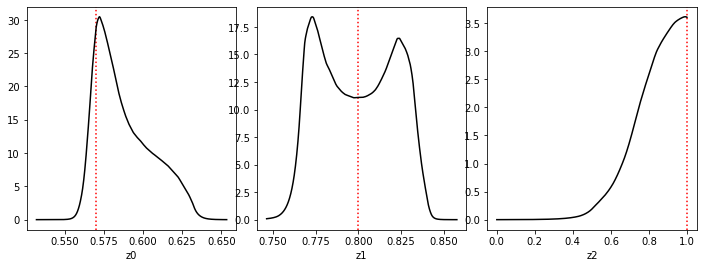

In [6]:
swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys', dims = (12, 4))

In [7]:
re2 = swyft.RatioEstimation(zdim, td, device = DEVICE, combinations = [[0, 1], [0, 2], [1, 2]])

In [8]:
re2.train(max_epochs = MAX_EPOCHS, nbatch = 32, lr_schedule = [1e-3, 3e-4, 1e-4])

Start training
LR iteration 0
Total epochs: 5
Validation losses: [5.510189950466156, 5.417412996292114, 5.266785711050034, 5.0656987726688385, 5.273354142904282]
LR iteration 1
Total epochs: 3
Validation losses: [4.779394030570984, 4.603584468364716, 4.898650035262108]
LR iteration 2
Total epochs: 2
Validation losses: [4.7891785800457, 4.820165276527405]


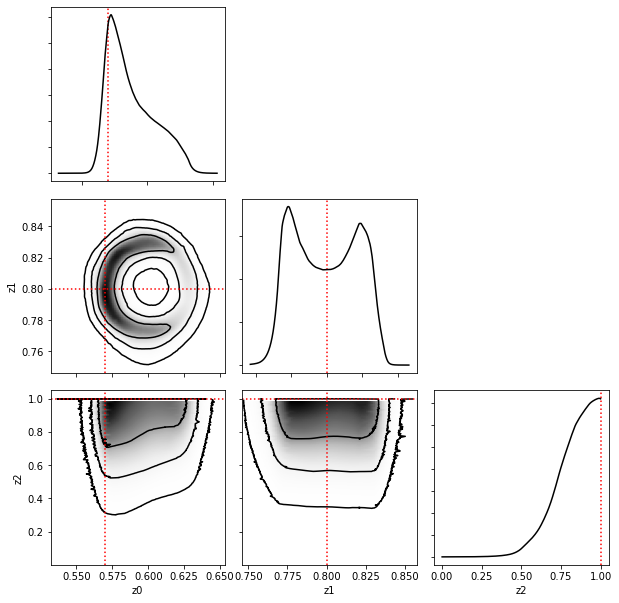

In [9]:
swyft.corner(re, re2, x0 = x0, z0 = z0, cmap = 'Greys', dim = 10)